## Résolution du FSP en utilisant des heuristiques.

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import random 
import pandas as pd

#### Lecture des instances de Taillard à partir d'un fichier txt

In [2]:
def get_data(filename, i,nb):
    nb = nb + 3
    with open(filename, 'r') as f:
        data = f.read()
    lines = data.split('\n')
    data = lines[i*nb:(i+1)*nb][3:]
    data = [x.split() for x in data]
    data = [[int(y) for y in x] for x in data]
    data = list(map(list, zip(*data)))

    nb_jobs = int(lines[i*nb:(i+1)*nb][1].split()[0])
    nb_machines = int(lines[i*nb:(i+1)*nb][1].split()[1])
    upper_bound = int(lines[i*nb:(i+1)*nb][1].split()[3])
    lower_bound = int(lines[i*nb:(i+1)*nb][1].split()[4])

    data = np.array(data).T
    return nb_jobs, nb_machines, upper_bound, lower_bound, data


#### Une classe pour définir et résoudre une instance de problème de flowshop

In [3]:
class Flowshop(object):

    def __init__(self, data, nb_machines, nb_jobs, max_time=100):
        """
            data : A 2D array of processing times on machines.
            nb_machines : Number of machines for the given problem must be the number of rows of first param.
            nb_jobs  : Number of jobs for the given problem, must be equal to the number of columns of the data param. 
        """
        self.nb_machines = nb_machines
        self.nb_jobs = nb_jobs
        self.data = data
        if data is None:
            self.data = self.generate_random(max_time)
            
    def generate_random(self, max_time):
        """
        Generates matrix of random processing times.
        Returns:
            ndarray of random processing times of shape (nb_machines, nb_jobs)
        """
        return np.random.randint(
            1,
            max_time,
            size=( self.nb_machines, self.nb_jobs )
        )
    
    def _get_makespan(self, seq, data):
        # Initialize a matrix 'c' of size nb_machines x len(seq) to hold the start and end times for each job on each machine
        c = np.zeros((self.nb_machines, len(seq)), dtype=object)
        
        # Fill in the first row of 'c' with the start and end times for the first job on each machine
        c[0][0] = (0, data[0][seq[0]])
        for m_id in range(1, self.nb_machines):
            s_t = c[m_id-1][0][1] # Get the end time of the last job on the previous machine
            e_t = s_t + data[m_id][0] # Calculate the end time of the first job on the current machine
            c[m_id][0] = (s_t, e_t) # Set the start and end times for the first job on the current machine
        
        # Fill in the rest of 'c' with the start and end times for each job on each machine
        if len(seq) > 1:
            for i, job_id in enumerate(seq[1::]):
                # Fill in the start and end times for the job on the first machine
                s_t = c[0][i][1] # Get the end time of the previous job on the first machine
                e_t = s_t + data[0][job_id] # Calculate the end time of the current job on the first machine
                c[0][i+1] = (s_t, e_t) # Set the start and end times for the current job on the first machine
                
                # Fill in the start and end times for the job on the rest of the machines
                for m_id in range(1, self.nb_machines):
                    s_t = max(c[m_id][i][1], c[m_id-1][i+1][1]) # Get the maximum of the end time of the previous job on the current machine and the end time of the current job on the previous machine
                    e_t = s_t + data[m_id][job_id] # Calculate the end time of the current job on the current machine
                    c[m_id][i+1] = (s_t, e_t) # Set the start and end times for the current job on the current machine
                    
        # Return the ending time of the last job on the last machine as the makespan
        return c[self.nb_machines-1][-1][1]

    def neh_heuristic(self):
        sums = []
        default_timer = time.time
        s = default_timer.__call__()

        for job_id in range(self.nb_jobs):
            #print(f"job_d = {job_id}")
            p_ij = sum([self.data[j,job_id]
                        for j in range(self.nb_machines)])
            sums.append((job_id, p_ij))
        sums.sort(key=lambda x: x[1], reverse=True)
        
        seq = []
        for job in sums:
            cands = []
            for i in range(0, len(seq) + 1):
                cand = seq[:i] + [job[0]] + seq[i:]
                cands.append((cand, self._get_makespan(cand, self.data)))
            seq = min(cands, key=lambda x: x[1])[0]

        e = default_timer.__call__()

        schedules = np.zeros((self.nb_machines, self.nb_jobs), dtype=dict)
        # schedule first job alone first
        task = {"name": "job_{}".format(
            seq[0]+1), "start_time": 0, "end_time": self.data[0][seq[0]]}
        schedules[0][0] = task
        for m_id in range(1, self.nb_machines):
            start_t = schedules[m_id-1][0]["end_time"]
            end_t = start_t + self.data[m_id][0]
            task = {"name": "job_{}".format(
                seq[0]+1), "start_time": start_t, "end_time": end_t}
            schedules[m_id][0] = task

        for index, job_id in enumerate(seq[1::]):
            start_t = schedules[0][index]["end_time"]
            end_t = start_t + self.data[0][job_id]
            task = {"name": "job_{}".format(
                job_id+1), "start_time": start_t, "end_time": end_t}
            schedules[0][index+1] = task
            for m_id in range(1, self.nb_machines):
                start_t = max(schedules[m_id][index]["end_time"],
                              schedules[m_id-1][index+1]["end_time"])
                end_t = start_t + self.data[m_id][job_id]
                task = {"name": "job_{}".format(
                    job_id+1), "start_time": start_t, "end_time": end_t}
                schedules[m_id][index+1] = task
        max_mkspn = int(schedules[self.nb_machines-1][-1]["end_time"])
        
        t_t = e - s
        return seq, schedules, max_mkspn, t_t

    def draw_gantt_chart(self,arr,interval=50,labeled=True):
        # create a new figure
        fig, ax = plt.subplots(figsize=(18, 8))

        # set y-axis ticks and labels
        y_ticks = list(range(len(arr)))
        y_labels = [f'Machine {i+1}' for i in y_ticks]
        ax.set_yticks(y_ticks)
        ax.set_yticklabels(y_labels)

        # calculate the total time
        total_time = max([job['end_time'] for proc in arr for job in proc])

        # set x-axis limits and ticks
        ax.set_xlim(0, total_time)
        x_ticks = list(range(0, total_time+1, interval))
        ax.set_xticks(x_ticks)

        # set grid lines
        ax.grid(True, axis='x', linestyle='--')

        # create a color dictionary to map each job to a color
        color_dict = {}
        for proc in arr:
            for job in proc:
                if job['name'] not in color_dict:
                    color_dict[job['name']] = (random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1))

        # plot the bars for each job on each processor
        for i, proc in enumerate(arr):
            for job in proc:
                start = job['start_time']
                end = job['end_time']
                duration = end - start
                color = color_dict[job['name']]
                ax.barh(i, duration, left=start, height=0.5, align='center', color=color, alpha=0.8)
                if labeled :
                # add job labels
                    label_x = start + duration/2
                    label_y = i 
                    ax.text(label_x, label_y, job['name'][4:], ha='center', va='center', fontsize=10)

        # set the chart title and axis labels
        ax.set_title('Diagramme de Gantt')
        ax.set_xlabel('Temps')
        #ax.set_ylabel('Machine')

        # show the chart
        plt.show()

    @staticmethod
    def johnson_seq(data):
        job_count = len(data)
        job_ids = list(range(0, job_count))
        l1 = []
        l2 = []
        for job_info in sorted(zip(job_ids, data), key=lambda t: min(t[1])):
            job_id = job_info[0]
            job_times = job_info[1]
            if job_times[0] < job_times[1]:
                l1.append(job_id)
            else:
                l2.insert(0, job_id)
        return l1 + l2
    
    def cds(self):

        data_ndarray = self.data
        data_transposed = data_ndarray.T
        default_timer = time.time
        s = default_timer.__call__()

        merged_times = [[0, sum(j_t)] for j_t in data_transposed]
        perms = []
        for i in range(0, self.nb_machines-1):
            for j in range(0, self.nb_jobs):
                merged_times[j][0] += data_transposed[j][i]
                merged_times[j][1] -= data_transposed[j][i]
            perms.append(Flowshop.johnson_seq(merged_times))
        
        seq = min(perms, key=lambda p: self._get_makespan(p, self.data))

        e = default_timer.__call__()

        schedules = np.zeros((self.nb_machines, self.nb_jobs), dtype=dict)
        # schedule first job alone first
        task = {"name": "job_{}".format(
            seq[0]+1), "start_time": 0, "end_time": self.data[0][seq[0]]}
        schedules[0][0] = task
        for m_id in range(1, self.nb_machines):
            start_t = schedules[m_id-1][0]["end_time"]
            end_t = start_t + self.data[m_id][0]
            task = {"name": "job_{}".format(
                seq[0]+1), "start_time": start_t, "end_time": end_t}
            schedules[m_id][0] = task

        for index, job_id in enumerate(seq[1::]):
            start_t = schedules[0][index]["end_time"]
            end_t = start_t + self.data[0][job_id]
            task = {"name": "job_{}".format(
                job_id+1), "start_time": start_t, "end_time": end_t}
            schedules[0][index+1] = task
            for m_id in range(1, self.nb_machines):
                start_t = max(schedules[m_id][index]["end_time"],
                              schedules[m_id-1][index+1]["end_time"])
                end_t = start_t + self.data[m_id][job_id]
                task = {"name": "job_{}".format(
                    job_id+1), "start_time": start_t, "end_time": end_t}
                schedules[m_id][index+1] = task
        max_mkspn = int(schedules[self.nb_machines-1][-1]["end_time"])
        t_t = e - s
        return seq, schedules, max_mkspn, t_t
    
    def palmer_heuristic(self):
        """solves an N machines M jobs pfsp problem using Palmer's Heuristic
        Returns:
            tuple -- a tuple containing the job sequence, scheduled jobs and optimal makespan.
        """

        def palmer_f(x): return -(self.nb_machines - (2*x - 1))
        
        default_timer = time.time
        s = default_timer.__call__()
        
        weights = list(map(palmer_f, range(1, self.nb_machines+1)))
        ws = []
        for job_id in range(self.nb_jobs):
            p_ij = sum([self.data[j][job_id]*weights[j]
                        for j in range(self.nb_machines)])
            ws.append((job_id, p_ij))
        ws.sort(key=lambda x: x[1], reverse=True)
        h_seq = [x[0] for x in ws]
        e = default_timer.__call__()
        schedules = np.zeros((self.nb_machines, self.nb_jobs), dtype=dict)
        # schedule first job alone first
        task = {"name": "job_{}".format(
            h_seq[0]+1), "start_time": 0, "end_time": self.data[0][h_seq[0]]}
        schedules[0][0] = task
        for m_id in range(1, self.nb_machines):
            start_t = schedules[m_id-1][0]["end_time"]
            end_t = start_t + self.data[m_id][0]
            task = {"name": "job_{}".format(
                h_seq[0]+1), "start_time": start_t, "end_time": end_t}
            schedules[m_id][0] = task

        for index, job_id in enumerate(h_seq[1::]):
            start_t = schedules[0][index]["end_time"]
            end_t = start_t + self.data[0][job_id]
            task = {"name": "job_{}".format(
                job_id+1), "start_time": start_t, "end_time": end_t}
            schedules[0][index+1] = task
            for m_id in range(1, self.nb_machines):
                start_t = max(schedules[m_id][index]["end_time"],
                              schedules[m_id-1][index+1]["end_time"])
                end_t = start_t + self.data[m_id][job_id]
                task = {"name": "job_{}".format(
                    job_id+1), "start_time": start_t, "end_time": end_t}
                schedules[m_id][index+1] = task
        opt_makespan = int(schedules[self.nb_machines-1][-1]["end_time"])
        t_t = e - s
        return h_seq, schedules, opt_makespan, t_t

## Tests 

#### 1. Instance 1 de taillard avec 20 jobs et 5 machines 

In [4]:
n_jobs, n_machines, ub,lb, processing_times = get_data("./taillard_instances/tai20_5.txt", 0,5)
fs = Flowshop(processing_times,n_machines,n_jobs)

##### - **NEH**

Cmax = 1323 | Upper Bound = 1278 | Lower Bound = 1232
Runtime = 0.045928955078125 s


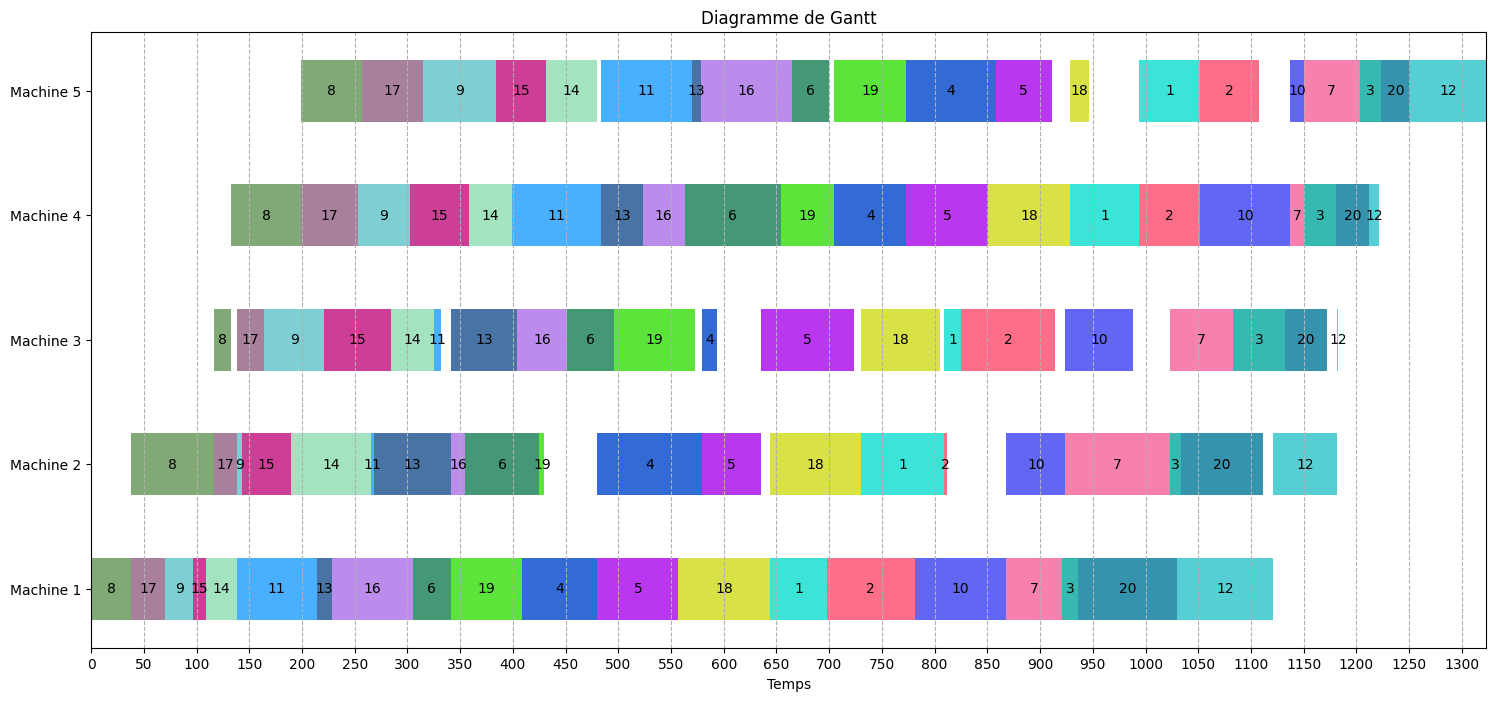

In [5]:
sequence_neh, schedules, cmax_neh, runtime_neh = fs.neh_heuristic()
print(f"Cmax = {cmax_neh} | Upper Bound = {ub} | Lower Bound = {lb}")
print(f"Runtime = {runtime_neh} s")
fs.draw_gantt_chart(schedules)

Instance 1  : Cmax = 1323 | UB = 1278 | Deviation = 0.035211267605633804
Instance 2  : Cmax = 1458 | UB = 1359 | Deviation = 0.0728476821192053
Instance 3  : Cmax = 1117 | UB = 1081 | Deviation = 0.03330249768732655
Instance 4  : Cmax = 1452 | UB = 1293 | Deviation = 0.12296983758700696
Instance 5  : Cmax = 1305 | UB = 1236 | Deviation = 0.055825242718446605
Instance 6  : Cmax = 1234 | UB = 1195 | Deviation = 0.032635983263598324
Instance 7  : Cmax = 1307 | UB = 1239 | Deviation = 0.05488297013720742
Instance 8  : Cmax = 1206 | UB = 1206 | Deviation = 0.0
Instance 9  : Cmax = 1350 | UB = 1230 | Deviation = 0.0975609756097561
Instance 10  : Cmax = 1193 | UB = 1108 | Deviation = 0.07671480144404332


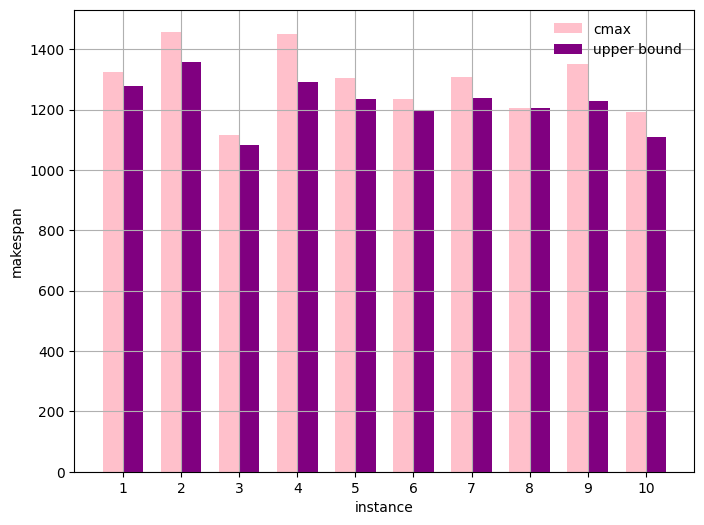

In [9]:
n = 10
width = 0.35
ind = np.arange(n)

fig, ax = plt.subplots(figsize=(8,6))

cmax_bars = []
ub_bars = []

for i in range(10):
    n_jobs, n_machines, ub,lb, processing_times = get_data("./taillard_instances/tai20_5.txt", i,5)
    fs = Flowshop(processing_times,n_machines,n_jobs)
    sequence_neh, schedules, cmax_neh, runtime_neh = fs.neh_heuristic()
    print(f"Instance {i+1}  : Cmax = {cmax_neh} | UB = {ub} | Deviation = {(cmax_neh - ub)/ub}")
    cmax_bar = ax.bar(ind[i] - width/2, cmax_neh, width, color='pink')
    ub_bar = ax.bar(ind[i] + width/2, ub, width, color='purple')
    
    cmax_bars.append(cmax_bar)
    ub_bars.append(ub_bar)

ax.set_xticks(ind)
ax.set_xticklabels([str(i+1) for i in range(n)])
ax.set_xlabel('instance')
ax.set_ylabel('makespan')
ax.legend([cmax_bars[0], ub_bars[0]], ['cmax', 'upper bound'], loc='upper right', frameon=False)
ax.grid(True)
plt.show()


##### - **CDS**

Cmax = 1366 | Upper Bound = 1278 | Lower Bound = 1232
Runtime = 0.0008294582366943359 s


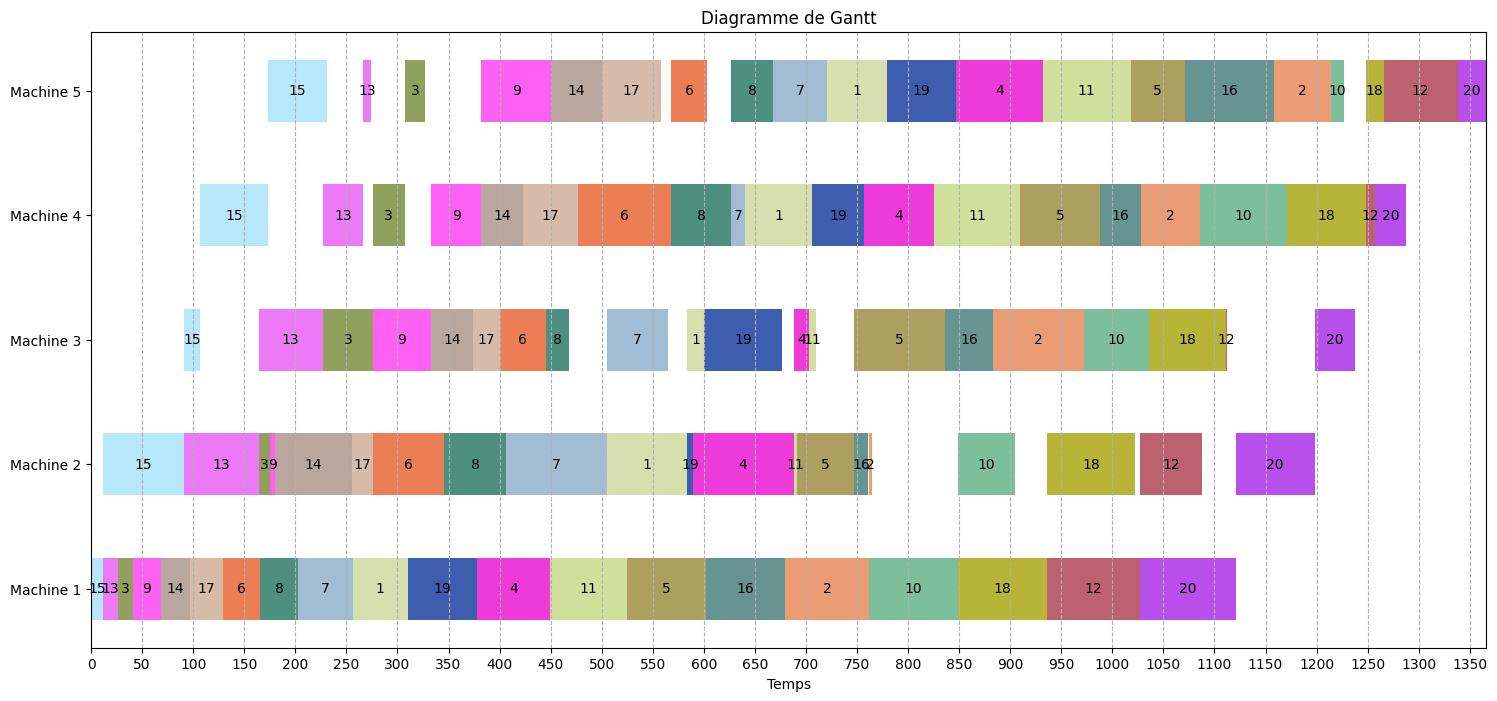

In [6]:
sequence_cds, schedules, cmax_cds, runtime_cds = fs.cds()
print(f"Cmax = {cmax_cds} | Upper Bound = {ub} | Lower Bound = {lb}")
print(f"Runtime = {runtime_cds} s")
fs.draw_gantt_chart(schedules)

Instance 1  : Cmax = 1366 | UB = 1278 | Deviation = 0.06885758998435054
Instance 2  : Cmax = 1458 | UB = 1359 | Deviation = 0.0728476821192053
Instance 3  : Cmax = 1260 | UB = 1081 | Deviation = 0.16558741905642924
Instance 4  : Cmax = 1499 | UB = 1293 | Deviation = 0.15931941221964424
Instance 5  : Cmax = 1313 | UB = 1236 | Deviation = 0.06229773462783172
Instance 6  : Cmax = 1292 | UB = 1195 | Deviation = 0.08117154811715481
Instance 7  : Cmax = 1374 | UB = 1239 | Deviation = 0.1089588377723971
Instance 8  : Cmax = 1329 | UB = 1206 | Deviation = 0.10199004975124377
Instance 9  : Cmax = 1399 | UB = 1230 | Deviation = 0.13739837398373983
Instance 10  : Cmax = 1269 | UB = 1108 | Deviation = 0.14530685920577618


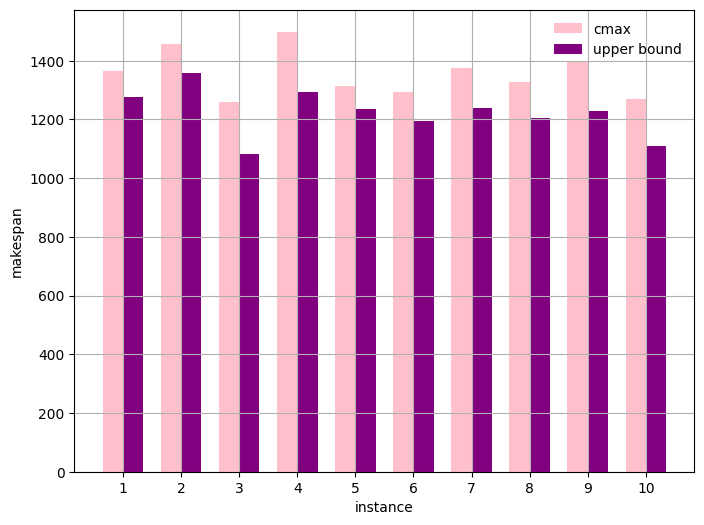

In [10]:
n = 10
width = 0.35
ind = np.arange(n)

fig, ax = plt.subplots(figsize=(8,6))

cmax_bars = []
ub_bars = []

for i in range(10):
    n_jobs, n_machines, ub,lb, processing_times = get_data("./taillard_instances/tai20_5.txt", i,5)
    fs = Flowshop(processing_times,n_machines,n_jobs)
    sequence_cds, schedules, cmax_cds, runtime_cds = fs.cds()
    print(f"Instance {i+1}  : Cmax = {cmax_cds} | UB = {ub} | Deviation = {(cmax_cds - ub)/ub}")
    cmax_bar = ax.bar(ind[i] - width/2, cmax_cds, width, color='pink')
    ub_bar = ax.bar(ind[i] + width/2, ub, width, color='purple')
    
    cmax_bars.append(cmax_bar)
    ub_bars.append(ub_bar)

ax.set_xticks(ind)
ax.set_xticklabels([str(i+1) for i in range(n)])
ax.set_xlabel('instance')
ax.set_ylabel('makespan')
ax.legend([cmax_bars[0], ub_bars[0]], ['cmax', 'upper bound'], loc='upper right', frameon=False)
ax.grid(True)
plt.show()


##### - **Palmer**

Cmax = 1384 | Upper Bound = 1278 | Lower Bound = 1232
Runtime = 0.0013470649719238281 s


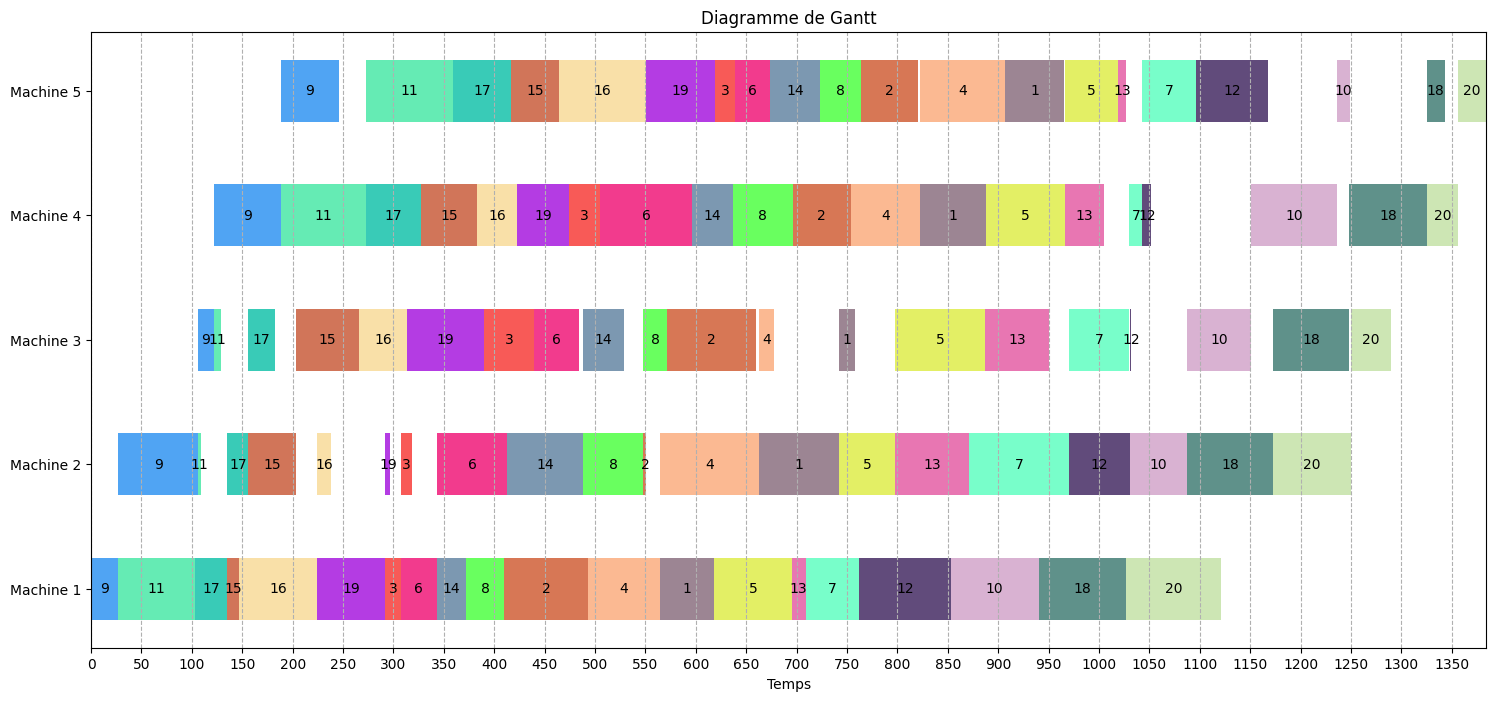

In [7]:
sequence_palmer, schedules, cmax_palmer, runtime_palmer = fs.palmer_heuristic()
print(f"Cmax = {cmax_palmer} | Upper Bound = {ub} | Lower Bound = {lb}")
print(f"Runtime = {runtime_palmer} s")
fs.draw_gantt_chart(schedules)

Instance 1  : Cmax = 1384 | UB = 1278 | Deviation = 0.08294209702660407
Instance 2  : Cmax = 1525 | UB = 1359 | Deviation = 0.12214863870493009
Instance 3  : Cmax = 1147 | UB = 1081 | Deviation = 0.06105457909343201
Instance 4  : Cmax = 1576 | UB = 1293 | Deviation = 0.2188708430007734
Instance 5  : Cmax = 1360 | UB = 1236 | Deviation = 0.10032362459546926
Instance 6  : Cmax = 1375 | UB = 1195 | Deviation = 0.1506276150627615
Instance 7  : Cmax = 1393 | UB = 1239 | Deviation = 0.12429378531073447
Instance 8  : Cmax = 1319 | UB = 1206 | Deviation = 0.09369817578772803
Instance 9  : Cmax = 1482 | UB = 1230 | Deviation = 0.2048780487804878
Instance 10  : Cmax = 1241 | UB = 1108 | Deviation = 0.12003610108303249


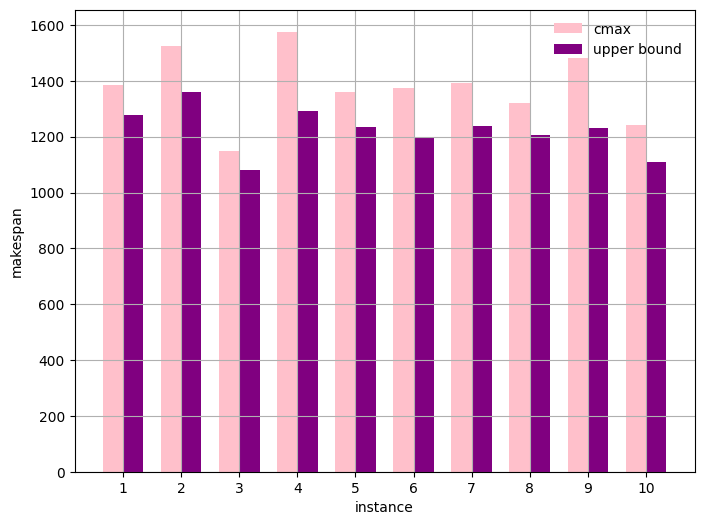

In [11]:
n = 10
width = 0.35
ind = np.arange(n)

fig, ax = plt.subplots(figsize=(8,6))

cmax_bars = []
ub_bars = []

for i in range(10):
    n_jobs, n_machines, ub,lb, processing_times = get_data("./taillard_instances/tai20_5.txt", i,5)
    fs = Flowshop(processing_times,n_machines,n_jobs)
    sequence_palmer, schedules, cmax_palmer, runtime_palmer = fs.palmer_heuristic()
    print(f"Instance {i+1}  : Cmax = {cmax_palmer} | UB = {ub} | Deviation = {(cmax_palmer - ub)/ub}")
    cmax_bar = ax.bar(ind[i] - width/2, cmax_palmer, width, color='pink')
    ub_bar = ax.bar(ind[i] + width/2, ub, width, color='purple')
    
    cmax_bars.append(cmax_bar)
    ub_bars.append(ub_bar)

ax.set_xticks(ind)
ax.set_xticklabels([str(i+1) for i in range(n)])
ax.set_xlabel('instance')
ax.set_ylabel('makespan')
ax.legend([cmax_bars[0], ub_bars[0]], ['cmax', 'upper bound'], loc='upper right', frameon=False)
ax.grid(True)
plt.show()


### Comparaison entre les 3 heuristiques

In [8]:
heuristics = ["NEH","CDS","Palmer"]
runtimes = [runtime_neh,runtime_cds,runtime_palmer]
cmaxes = [cmax_neh,cmax_cds,cmax_palmer]
deviations = [(cmax-ub)/ub for cmax in cmaxes]
comparaison = pd.DataFrame( {
    "Heuristique" : heuristics,
    "Temps d'execution" : runtimes,
    "Cmax" : cmaxes,
    "Deviation" : deviations}
)
comparaison.style.hide(axis="index")

Heuristique,Temps d'execution,Cmax,Deviation
NEH,0.045929,1323,0.035211
CDS,0.000829,1366,0.068858
Palmer,0.001347,1384,0.082942


#### 2. Une instance de taillard avec 20 jobs et 10 machines 

In [12]:
n_jobs, n_machines,ub,lb, processing_times = get_data("./taillard_instances/tai20_10.txt", 0,10)
fs = Flowshop(processing_times,n_machines,n_jobs)

##### - **NEH**

Cmax = 1718 | Upper Bound = 1582 | Lower Bound = 1448
Runtime = 0.05913114547729492 s


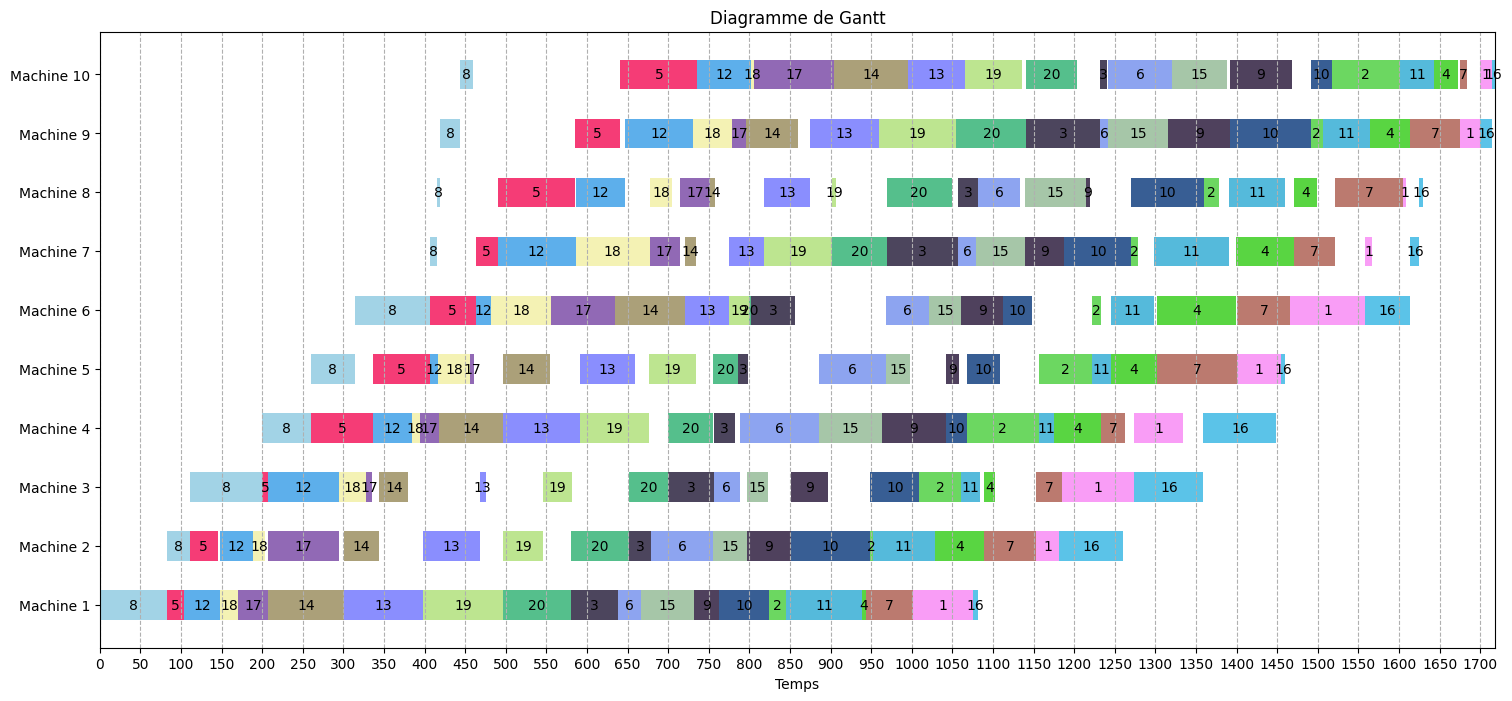

In [13]:
sequence_neh, schedules, cmax_neh, runtime_neh = fs.neh_heuristic()
print(f"Cmax = {cmax_neh} | Upper Bound = {ub} | Lower Bound = {lb}")
print(f"Runtime = {runtime_neh} s")
fs.draw_gantt_chart(schedules)

Instance 1  : Cmax = 1718 | UB = 1582 | Deviation = 0.08596713021491782
Instance 2  : Cmax = 1687 | UB = 1659 | Deviation = 0.016877637130801686
Instance 3  : Cmax = 1539 | UB = 1496 | Deviation = 0.02874331550802139
Instance 4  : Cmax = 1375 | UB = 1378 | Deviation = -0.0021770682148040637
Instance 5  : Cmax = 1603 | UB = 1419 | Deviation = 0.12966878083157152
Instance 6  : Cmax = 1489 | UB = 1397 | Deviation = 0.0658554044380816
Instance 7  : Cmax = 1613 | UB = 1484 | Deviation = 0.08692722371967655
Instance 8  : Cmax = 1710 | UB = 1538 | Deviation = 0.11183355006501951
Instance 9  : Cmax = 1652 | UB = 1593 | Deviation = 0.037037037037037035
Instance 10  : Cmax = 1704 | UB = 1591 | Deviation = 0.071024512884978


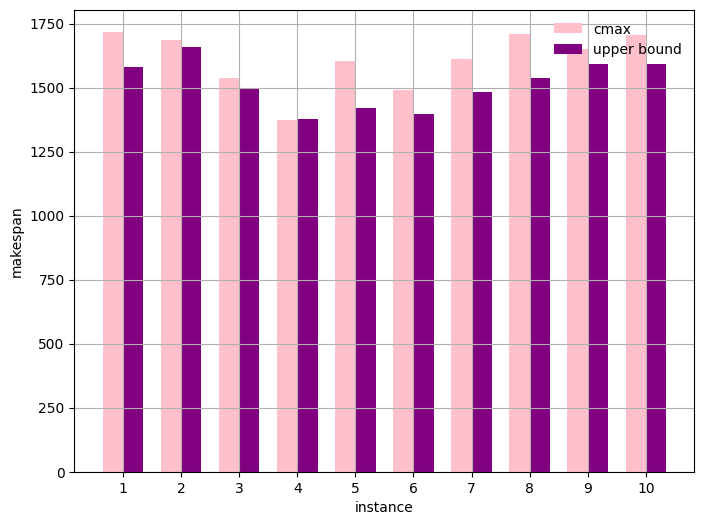

In [17]:
n = 10
width = 0.35
ind = np.arange(n)

fig, ax = plt.subplots(figsize=(8,6))

cmax_bars = []
ub_bars = []

for i in range(10):
    n_jobs, n_machines,ub,lb, processing_times = get_data("./taillard_instances/tai20_10.txt", i,10)
    fs = Flowshop(processing_times,n_machines,n_jobs)
    sequence_neh, schedules, cmax_neh, runtime_neh = fs.neh_heuristic()
    print(f"Instance {i+1}  : Cmax = {cmax_neh} | UB = {ub} | Deviation = {(cmax_neh - ub)/ub}")
    cmax_bar = ax.bar(ind[i] - width/2, cmax_neh, width, color='pink')
    ub_bar = ax.bar(ind[i] + width/2, ub, width, color='purple')
    
    cmax_bars.append(cmax_bar)
    ub_bars.append(ub_bar)

ax.set_xticks(ind)
ax.set_xticklabels([str(i+1) for i in range(n)])
ax.set_xlabel('instance')
ax.set_ylabel('makespan')
ax.legend([cmax_bars[0], ub_bars[0]], ['cmax', 'upper bound'], loc='upper right', frameon=False)
ax.grid(True)
plt.show()


##### - **CDS**

Cmax = 1815 | Upper Bound = 1582 | Lower Bound = 1448
Runtime = 0.0032444000244140625 s


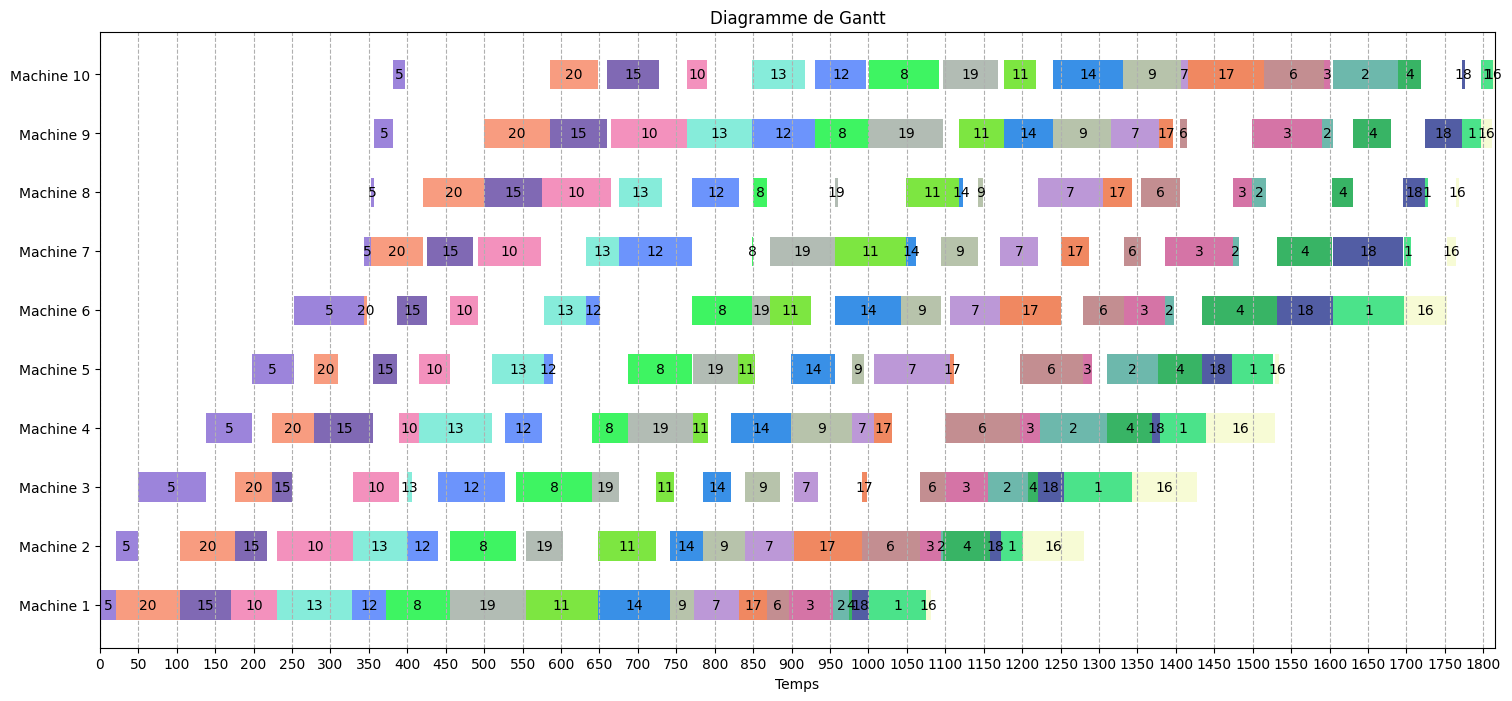

In [14]:
sequence_cds, schedules, cmax_cds, runtime_cds = fs.cds()
print(f"Cmax = {cmax_cds} | Upper Bound = {ub} | Lower Bound = {lb}")
print(f"Runtime = {runtime_cds} s")
fs.draw_gantt_chart(schedules)

Instance 1  : Cmax = 1815 | UB = 1582 | Deviation = 0.1472819216182048
Instance 2  : Cmax = 1971 | UB = 1659 | Deviation = 0.18806509945750452
Instance 3  : Cmax = 1735 | UB = 1496 | Deviation = 0.15975935828877005
Instance 4  : Cmax = 1572 | UB = 1378 | Deviation = 0.14078374455732948
Instance 5  : Cmax = 1654 | UB = 1419 | Deviation = 0.16560958421423538
Instance 6  : Cmax = 1595 | UB = 1397 | Deviation = 0.14173228346456693
Instance 7  : Cmax = 1671 | UB = 1484 | Deviation = 0.12601078167115903
Instance 8  : Cmax = 1904 | UB = 1538 | Deviation = 0.23797139141742524
Instance 9  : Cmax = 1735 | UB = 1593 | Deviation = 0.08913998744507219
Instance 10  : Cmax = 1859 | UB = 1591 | Deviation = 0.1684475172847266


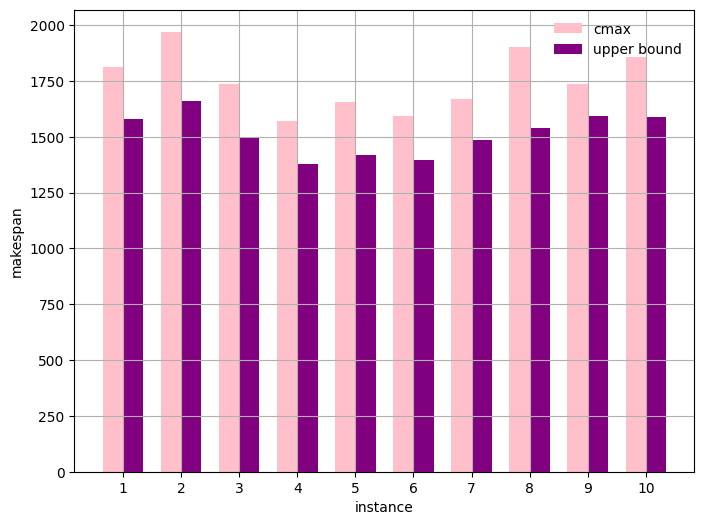

In [18]:
n = 10
width = 0.35
ind = np.arange(n)

fig, ax = plt.subplots(figsize=(8,6))

cmax_bars = []
ub_bars = []

for i in range(10):
    n_jobs, n_machines,ub,lb, processing_times = get_data("./taillard_instances/tai20_10.txt", i,10)
    fs = Flowshop(processing_times,n_machines,n_jobs)
    sequence_cds, schedules, cmax_cds, runtime_cds = fs.cds()
    print(f"Instance {i+1}  : Cmax = {cmax_cds} | UB = {ub} | Deviation = {(cmax_cds - ub)/ub}")
    cmax_bar = ax.bar(ind[i] - width/2, cmax_cds, width, color='pink')
    ub_bar = ax.bar(ind[i] + width/2, ub, width, color='purple')
    
    cmax_bars.append(cmax_bar)
    ub_bars.append(ub_bar)

ax.set_xticks(ind)
ax.set_xticklabels([str(i+1) for i in range(n)])
ax.set_xlabel('instance')
ax.set_ylabel('makespan')
ax.legend([cmax_bars[0], ub_bars[0]], ['cmax', 'upper bound'], loc='upper right', frameon=False)
ax.grid(True)
plt.show()


##### - **Palmer**

Cmax = 1822 | Upper Bound = 1582 | Lower Bound = 1448
Runtime = 0.0008797645568847656 s


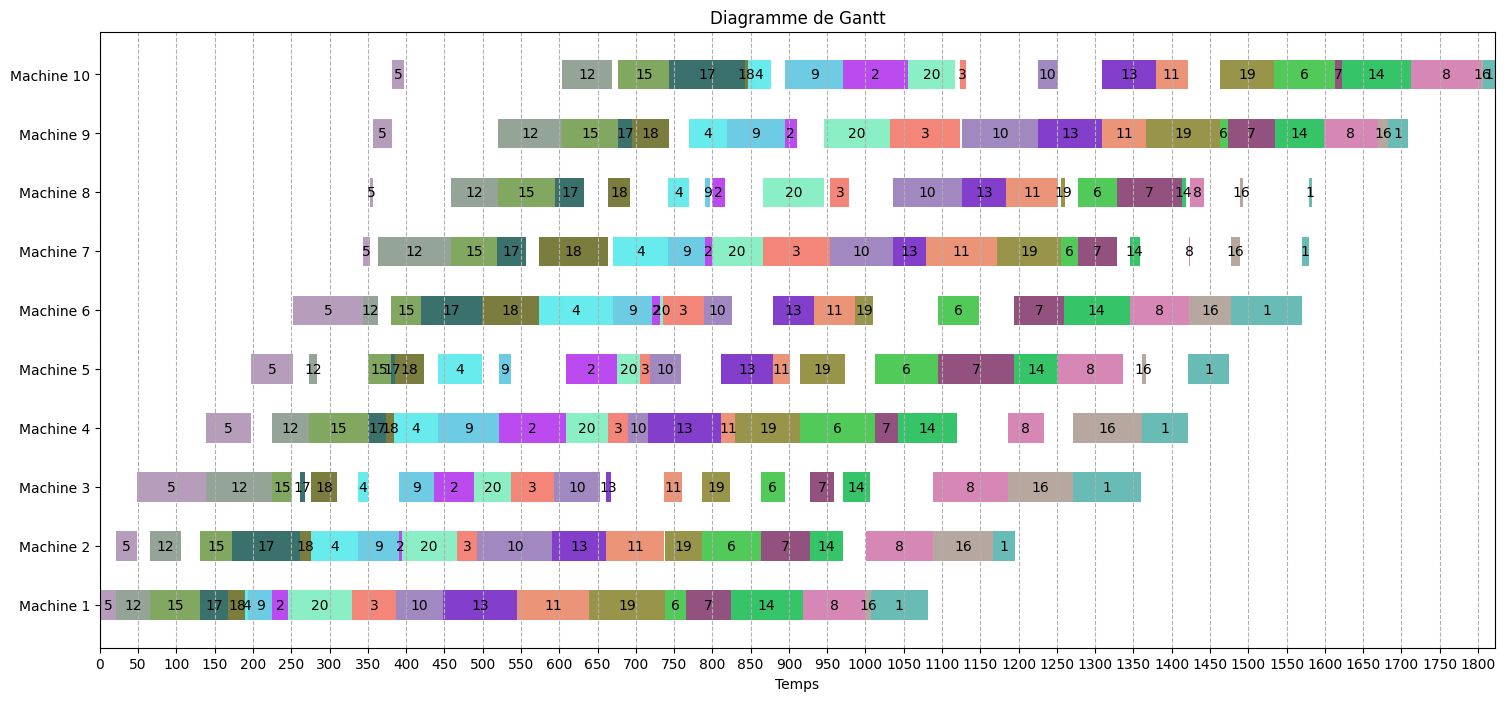

In [15]:
sequence_palmer, schedules, cmax_palmer, runtime_palmer = fs.palmer_heuristic()
print(f"Cmax = {cmax_palmer} | Upper Bound = {ub} | Lower Bound = {lb}")
print(f"Runtime = {runtime_palmer} s")
fs.draw_gantt_chart(schedules)

Instance 1  : Cmax = 1822 | UB = 1582 | Deviation = 0.15170670037926676
Instance 2  : Cmax = 1937 | UB = 1659 | Deviation = 0.1675708257986739
Instance 3  : Cmax = 1729 | UB = 1496 | Deviation = 0.1557486631016043
Instance 4  : Cmax = 1551 | UB = 1378 | Deviation = 0.125544267053701
Instance 5  : Cmax = 1720 | UB = 1419 | Deviation = 0.21212121212121213
Instance 6  : Cmax = 1588 | UB = 1397 | Deviation = 0.13672154617036505
Instance 7  : Cmax = 1735 | UB = 1484 | Deviation = 0.16913746630727763
Instance 8  : Cmax = 1876 | UB = 1538 | Deviation = 0.21976592977893367
Instance 9  : Cmax = 1831 | UB = 1593 | Deviation = 0.14940364092906466
Instance 10  : Cmax = 1888 | UB = 1591 | Deviation = 0.18667504714016342


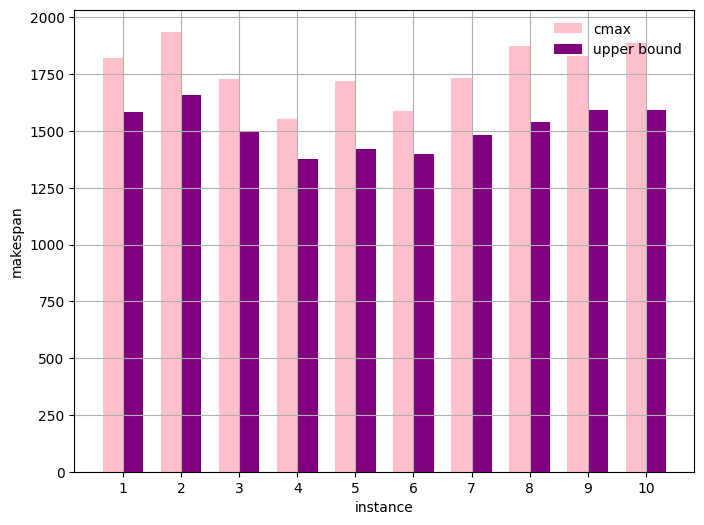

In [19]:
n = 10
width = 0.35
ind = np.arange(n)

fig, ax = plt.subplots(figsize=(8,6))

cmax_bars = []
ub_bars = []

for i in range(10):
    n_jobs, n_machines,ub,lb, processing_times = get_data("./taillard_instances/tai20_10.txt", i,10)
    fs = Flowshop(processing_times,n_machines,n_jobs)
    sequence_palmer, schedules, cmax_palmer, runtime_palmer= fs.palmer_heuristic()
    print(f"Instance {i+1}  : Cmax = {cmax_palmer} | UB = {ub} | Deviation = {(cmax_palmer - ub)/ub}")
    cmax_bar = ax.bar(ind[i] - width/2, cmax_palmer, width, color='pink')
    ub_bar = ax.bar(ind[i] + width/2, ub, width, color='purple')
    
    cmax_bars.append(cmax_bar)
    ub_bars.append(ub_bar)

ax.set_xticks(ind)
ax.set_xticklabels([str(i+1) for i in range(n)])
ax.set_xlabel('instance')
ax.set_ylabel('makespan')
ax.legend([cmax_bars[0], ub_bars[0]], ['cmax', 'upper bound'], loc='upper right', frameon=False)
ax.grid(True)
plt.show()


### Comparaison entre les 3 heuristiques

In [16]:
heuristics = ["NEH","CDS","Palmer"]
runtimes = [runtime_neh,runtime_cds,runtime_palmer]
cmaxes = [cmax_neh,cmax_cds,cmax_palmer]
deviations = [(cmax-ub)/ub for cmax in cmaxes]
comparaison = pd.DataFrame( {
    "Heuristique" : heuristics,
    "Temps d'execution" : runtimes,
    "Cmax" : cmaxes,
    "Deviation" : deviations}
)
comparaison.style.hide(axis="index")

Heuristique,Temps d'execution,Cmax,Deviation
NEH,0.059131,1718,0.085967
CDS,0.003244,1815,0.147282
Palmer,0.000880,1822,0.151707


#### 3. Une instance de taillard avec 100 jobs et 20 machines 

In [20]:
n_jobs, n_machines,ub,lb, processing_times = get_data("./taillard_instances/tai100_20.txt", 0,20)
fs = Flowshop(processing_times,n_machines,n_jobs)

##### - **NEH**

Cmax = 6572 | Upper Bound = 6286 | Lower Bound = 5851
Runtime = 6.011734485626221 s
Job Sequence : [9, 21, 53, 32, 58, 76, 99, 77, 45, 54, 4, 74, 10, 59, 81, 30, 47, 20, 93, 65, 38, 73, 82, 23, 15, 92, 49, 69, 29, 56, 94, 11, 34, 85, 68, 22, 19, 71, 52, 33, 98, 55, 3, 80, 42, 24, 31, 66, 18, 40, 97, 13, 5, 88, 16, 91, 28, 44, 84, 90, 89, 37, 17, 46, 39, 64, 61, 43, 79, 60, 48, 50, 95, 35, 78, 83, 26, 1, 8, 75, 27, 2, 62, 86, 67, 72, 70, 0, 36, 25, 63, 14, 87, 51, 96, 7, 41, 12, 57, 6]


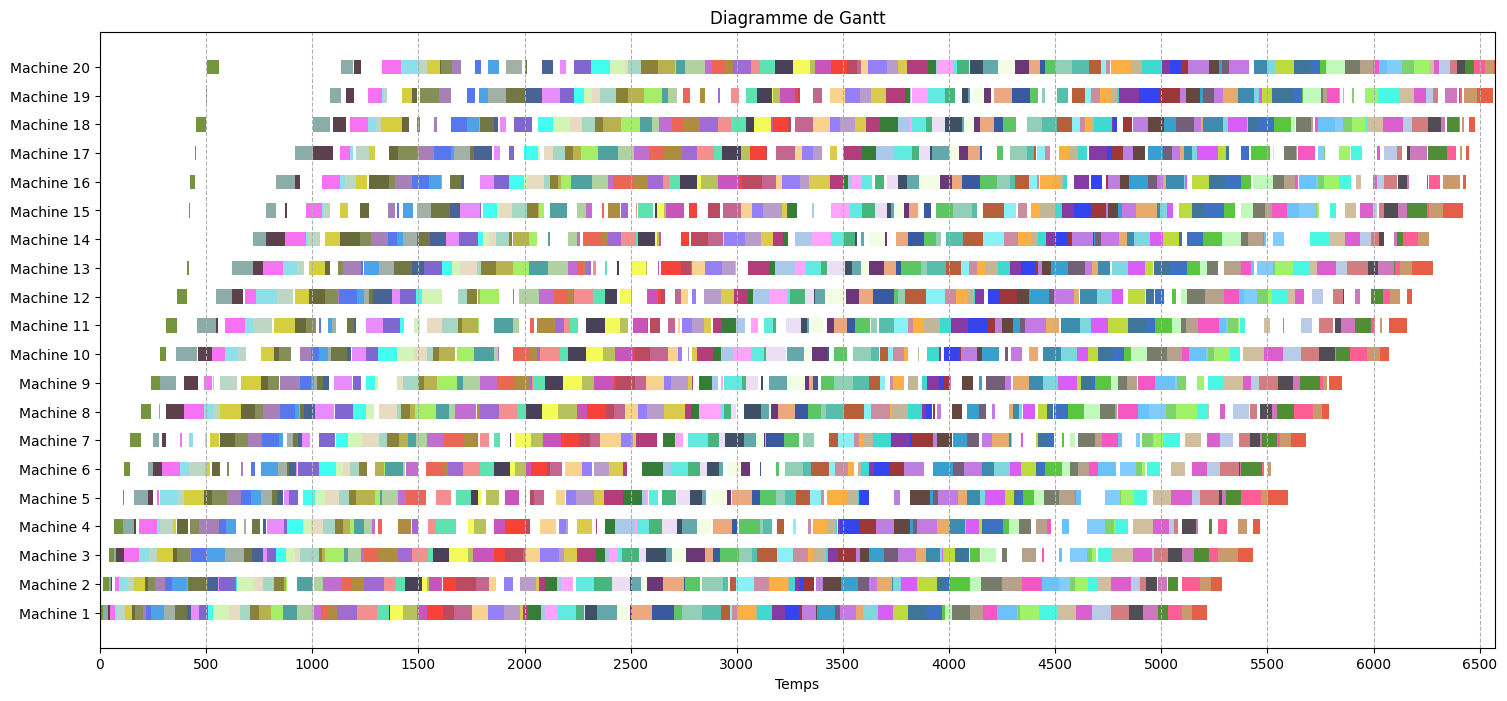

In [21]:
sequence_neh, schedules, cmax_neh, runtime_neh = fs.neh_heuristic()
print(f"Cmax = {cmax_neh} | Upper Bound = {ub} | Lower Bound = {lb}")
print(f"Runtime = {runtime_neh} s")
print(f"Job Sequence : {sequence_neh}")
fs.draw_gantt_chart(schedules,500,False)

Instance 1  : Cmax = 6572 | UB = 6286 | Deviation = 0.04549793191218581
Instance 2  : Cmax = 6632 | UB = 6241 | Deviation = 0.06265021631148854
Instance 3  : Cmax = 6632 | UB = 6329 | Deviation = 0.04787486174751145
Instance 4  : Cmax = 6631 | UB = 6306 | Deviation = 0.051538217570567715
Instance 5  : Cmax = 6731 | UB = 6377 | Deviation = 0.055511996236474834
Instance 6  : Cmax = 6749 | UB = 6437 | Deviation = 0.048469784060897934
Instance 7  : Cmax = 6729 | UB = 6346 | Deviation = 0.06035297825401828
Instance 8  : Cmax = 6778 | UB = 6481 | Deviation = 0.045826261379416755
Instance 9  : Cmax = 6667 | UB = 6358 | Deviation = 0.04860018873859704
Instance 10  : Cmax = 6751 | UB = 6465 | Deviation = 0.044238205723124514


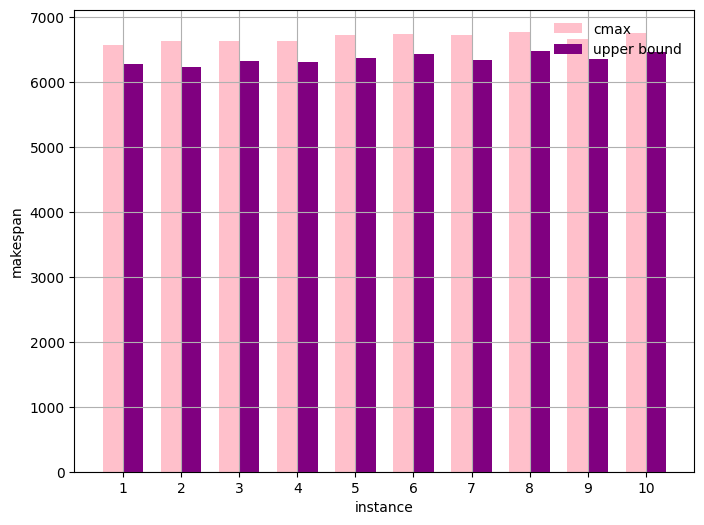

In [24]:
n = 10
width = 0.35
ind = np.arange(n)

fig, ax = plt.subplots(figsize=(8,6))

cmax_bars = []
ub_bars = []

for i in range(10):
    n_jobs, n_machines,ub,lb, processing_times = get_data("./taillard_instances/tai100_20.txt", i,20)
    fs = Flowshop(processing_times,n_machines,n_jobs)
    sequence_neh, schedules, cmax_neh, runtime_neh = fs.neh_heuristic()
    print(f"Instance {i+1}  : Cmax = {cmax_neh} | UB = {ub} | Deviation = {(cmax_neh - ub)/ub}")
    cmax_bar = ax.bar(ind[i] - width/2, cmax_neh, width, color='pink')
    ub_bar = ax.bar(ind[i] + width/2, ub, width, color='purple')
    
    cmax_bars.append(cmax_bar)
    ub_bars.append(ub_bar)

ax.set_xticks(ind)
ax.set_xticklabels([str(i+1) for i in range(n)])
ax.set_xlabel('instance')
ax.set_ylabel('makespan')
ax.legend([cmax_bars[0], ub_bars[0]], ['cmax', 'upper bound'], loc='upper right', frameon=False)
ax.grid(True)
plt.show()


##### - **CDS**

Cmax = 7263 | Upper Bound = 6286 | Lower Bound = 5851
Runtime = 0.08355474472045898 s
Job Sequence : [80, 82, 32, 78, 47, 8, 20, 98, 99, 84, 16, 38, 34, 93, 79, 39, 11, 36, 21, 2, 90, 60, 33, 9, 17, 5, 43, 14, 73, 23, 56, 97, 95, 55, 75, 59, 85, 92, 66, 61, 3, 50, 63, 10, 45, 31, 44, 19, 22, 81, 28, 74, 62, 91, 94, 42, 69, 52, 29, 1, 58, 30, 4, 64, 53, 87, 18, 15, 51, 88, 72, 57, 54, 25, 27, 70, 6, 0, 65, 41, 26, 96, 49, 86, 67, 89, 48, 46, 37, 13, 83, 35, 7, 71, 76, 24, 40, 12, 77, 68]


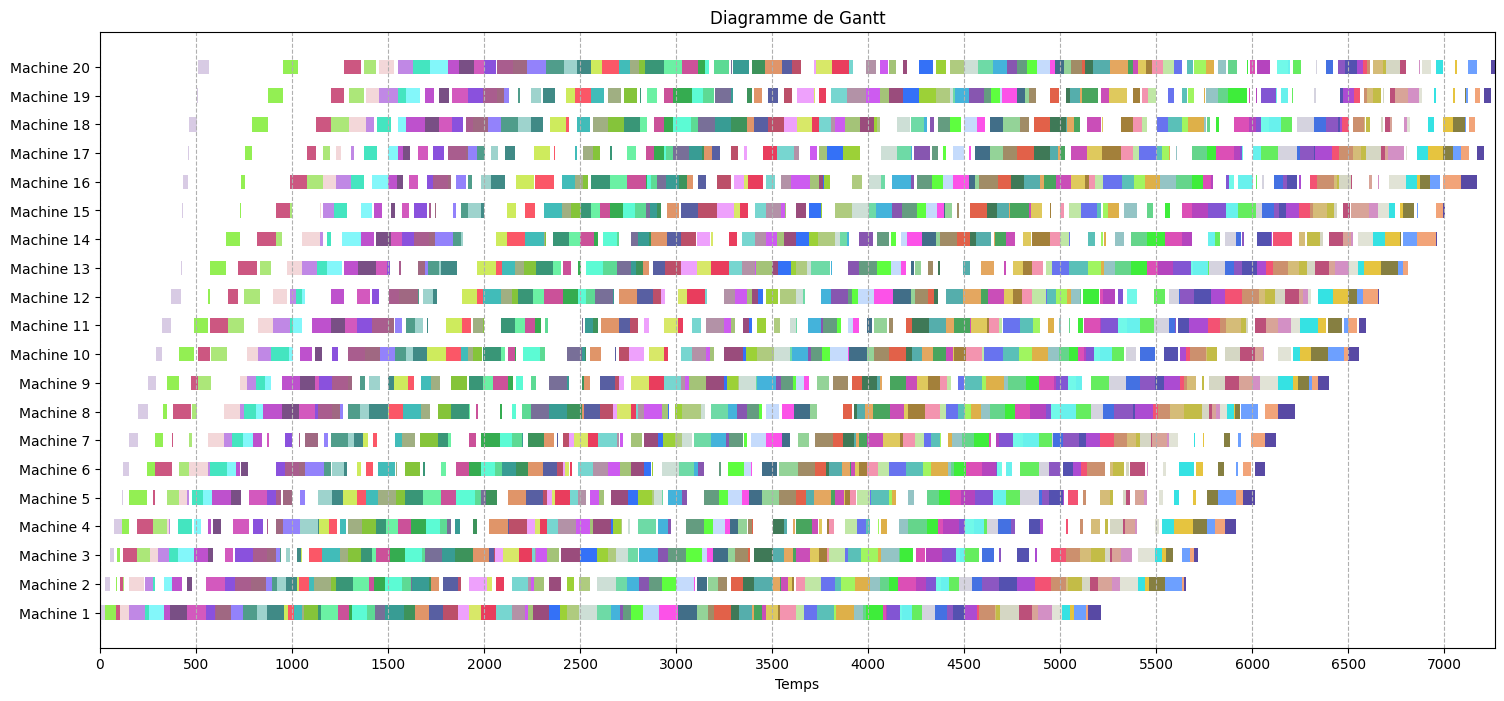

In [22]:
sequence_cds, schedules, cmax_cds, runtime_cds = fs.cds()
print(f"Cmax = {cmax_cds} | Upper Bound = {ub} | Lower Bound = {lb}")
print(f"Runtime = {runtime_cds} s")
print(f"Job Sequence : {sequence_cds}")
fs.draw_gantt_chart(schedules,500, False)

Instance 1  : Cmax = 7263 | UB = 6286 | Deviation = 0.15542475342029907
Instance 2  : Cmax = 7089 | UB = 6241 | Deviation = 0.13587566095177056
Instance 3  : Cmax = 7198 | UB = 6329 | Deviation = 0.13730447148048666
Instance 4  : Cmax = 7007 | UB = 6306 | Deviation = 0.1111639708214399
Instance 5  : Cmax = 7370 | UB = 6377 | Deviation = 0.15571585384977263
Instance 6  : Cmax = 7293 | UB = 6437 | Deviation = 0.1329812024234892
Instance 7  : Cmax = 7427 | UB = 6346 | Deviation = 0.17034352347935708
Instance 8  : Cmax = 7502 | UB = 6481 | Deviation = 0.1575374170652677
Instance 9  : Cmax = 7428 | UB = 6358 | Deviation = 0.16829191569676
Instance 10  : Cmax = 7344 | UB = 6465 | Deviation = 0.1359628770301624


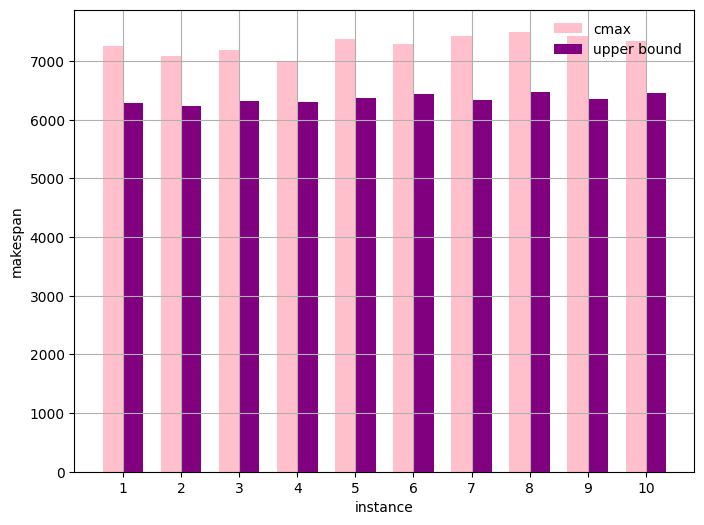

In [25]:
n = 10
width = 0.35
ind = np.arange(n)

fig, ax = plt.subplots(figsize=(8,6))

cmax_bars = []
ub_bars = []

for i in range(10):
    n_jobs, n_machines,ub,lb, processing_times = get_data("./taillard_instances/tai100_20.txt", i,20)
    fs = Flowshop(processing_times,n_machines,n_jobs)
    sequence_cds, schedules, cmax_cds, runtime_cds = fs.cds()
    print(f"Instance {i+1}  : Cmax = {cmax_cds} | UB = {ub} | Deviation = {(cmax_cds - ub)/ub}")
    cmax_bar = ax.bar(ind[i] - width/2, cmax_cds, width, color='pink')
    ub_bar = ax.bar(ind[i] + width/2, ub, width, color='purple')
    
    cmax_bars.append(cmax_bar)
    ub_bars.append(ub_bar)

ax.set_xticks(ind)
ax.set_xticklabels([str(i+1) for i in range(n)])
ax.set_xlabel('instance')
ax.set_ylabel('makespan')
ax.legend([cmax_bars[0], ub_bars[0]], ['cmax', 'upper bound'], loc='upper right', frameon=False)
ax.grid(True)
plt.show()


##### - **Palmer**

Cmax = 7075
Runtime = 0.004489898681640625 s
Job Sequence : [21, 32, 80, 78, 81, 53, 34, 64, 82, 8, 20, 75, 10, 23, 39, 30, 31, 98, 73, 2, 61, 3, 47, 92, 54, 59, 15, 77, 84, 52, 79, 24, 9, 5, 90, 99, 88, 91, 45, 36, 4, 38, 50, 55, 46, 58, 29, 17, 43, 69, 60, 1, 27, 7, 11, 0, 76, 89, 87, 83, 56, 66, 57, 65, 67, 16, 44, 85, 28, 40, 49, 70, 13, 26, 93, 22, 97, 95, 37, 19, 74, 35, 18, 42, 62, 71, 41, 96, 33, 25, 94, 51, 48, 6, 72, 68, 86, 12, 14, 63]


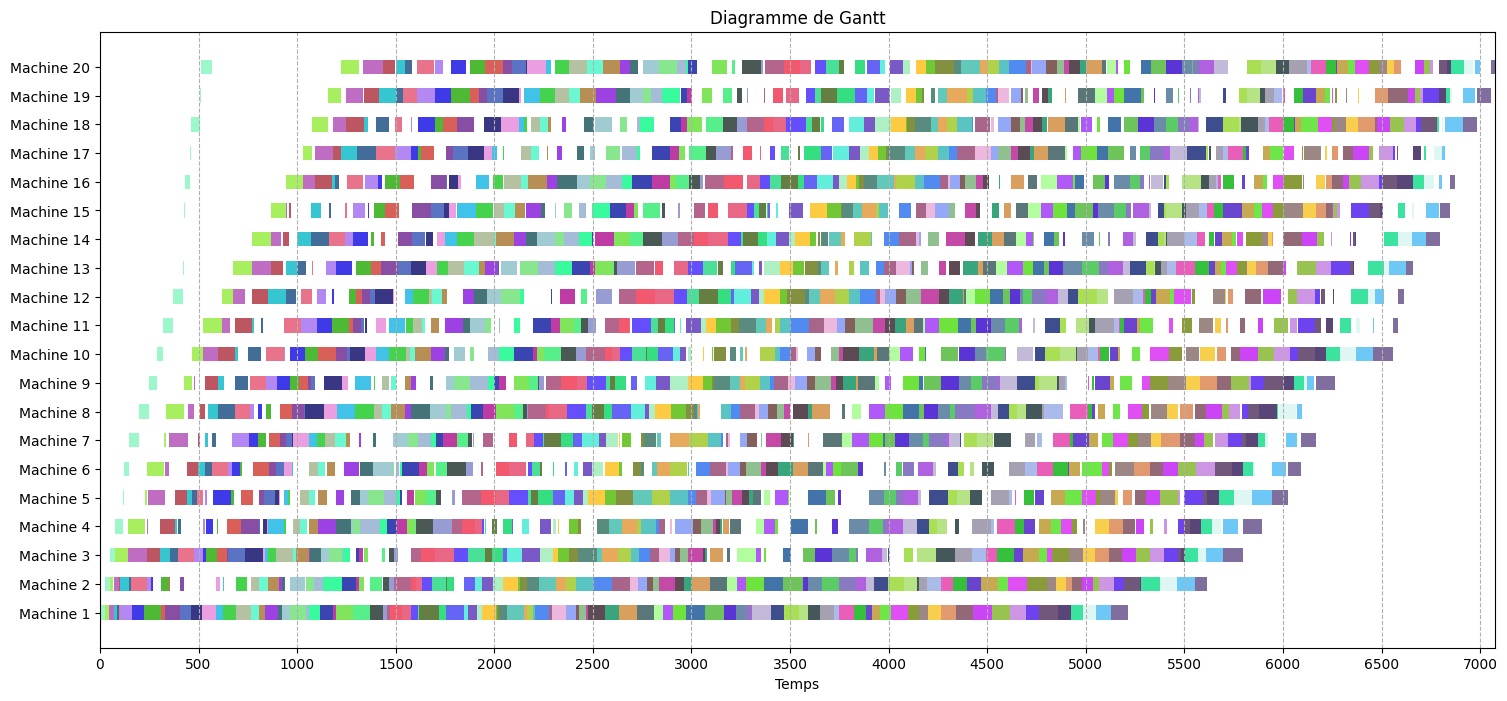

In [23]:
sequence_palmer, schedules, cmax_palmer, runtime_palmer = fs.palmer_heuristic()
print(f"Cmax = {cmax_palmer}")
print(f"Runtime = {runtime_palmer} s")
print(f"Job Sequence : {sequence_palmer}")
fs.draw_gantt_chart(schedules,500,False)

Instance 1  : Cmax = 7075 | UB = 6286 | Deviation = 0.12551702195354755
Instance 2  : Cmax = 7146 | UB = 6241 | Deviation = 0.145008812690274
Instance 3  : Cmax = 7399 | UB = 6329 | Deviation = 0.16906304313477644
Instance 4  : Cmax = 7039 | UB = 6306 | Deviation = 0.1162385030130035
Instance 5  : Cmax = 7366 | UB = 6377 | Deviation = 0.1550885996550102
Instance 6  : Cmax = 7109 | UB = 6437 | Deviation = 0.10439645797731863
Instance 7  : Cmax = 7293 | UB = 6346 | Deviation = 0.14922786006933503
Instance 8  : Cmax = 7567 | UB = 6481 | Deviation = 0.16756673352877643
Instance 9  : Cmax = 7317 | UB = 6358 | Deviation = 0.15083359547027367
Instance 10  : Cmax = 7289 | UB = 6465 | Deviation = 0.1274555297757154


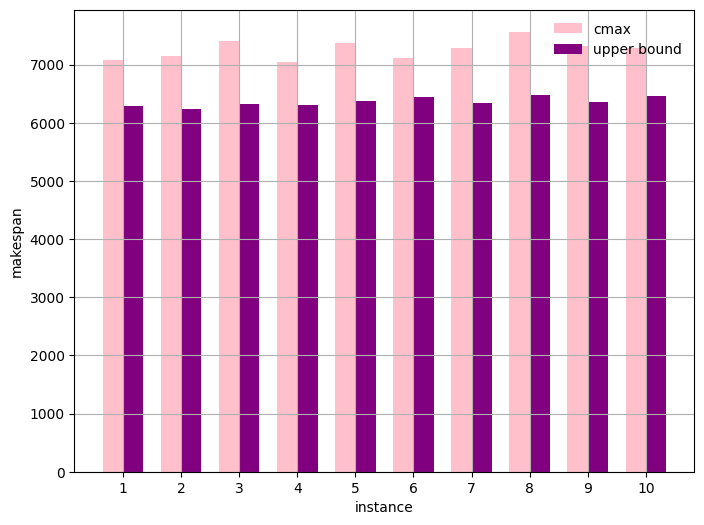

In [26]:
n = 10
width = 0.35
ind = np.arange(n)

fig, ax = plt.subplots(figsize=(8,6))

cmax_bars = []
ub_bars = []

for i in range(10):
    n_jobs, n_machines,ub,lb, processing_times = get_data("./taillard_instances/tai100_20.txt", i,20)
    fs = Flowshop(processing_times,n_machines,n_jobs)
    sequence_palmer, schedules, cmax_palmer, runtime_palmer = fs.palmer_heuristic()
    print(f"Instance {i+1}  : Cmax = {cmax_palmer} | UB = {ub} | Deviation = {(cmax_palmer - ub)/ub}")
    cmax_bar = ax.bar(ind[i] - width/2, cmax_palmer, width, color='pink')
    ub_bar = ax.bar(ind[i] + width/2, ub, width, color='purple')
    
    cmax_bars.append(cmax_bar)
    ub_bars.append(ub_bar)

ax.set_xticks(ind)
ax.set_xticklabels([str(i+1) for i in range(n)])
ax.set_xlabel('instance')
ax.set_ylabel('makespan')
ax.legend([cmax_bars[0], ub_bars[0]], ['cmax', 'upper bound'], loc='upper right', frameon=False)
ax.grid(True)
plt.show()


### Comparaison entre les 3 heuristiques

In [44]:
heuristics = ["NEH","CDS","Palmer"]
runtimes = [runtime_neh,runtime_cds,runtime_palmer]
cmaxes = [cmax_neh,cmax_cds,cmax_palmer]
deviations = [(cmax-ub)/ub for cmax in cmaxes]
comparaison = pd.DataFrame( {
    "Heuristique" : heuristics,
    "Temps d'execution" : runtimes,
    "Cmax" : cmaxes,
    "Deviation" : deviations}
)
comparaison.style.hide(axis="index")

Heuristique,Temps d'execution,Cmax,Deviation
NEH,8.224241,6572,0.016551
CDS,0.066539,7344,0.135963
Palmer,0.001338,7289,0.127456


#### 3. Une instance de taillard avec 500 jobs et 20 machines 

In [46]:
n_jobs, n_machines,ub,lb, processing_times = get_data("./taillard_instances/tai500_20.txt", 0,20)
fs = Flowshop(processing_times,n_machines,n_jobs)

##### - **NEH**

Cmax = 26838 | Upper Bound = 26189 | Lower Bound = 25922
Runtime = 974.5499563217163 s
Job Sequence : [332, 182, 378, 294, 87, 451, 484, 410, 158, 61, 115, 406, 490, 422, 52, 281, 213, 368, 166, 197, 262, 449, 15, 159, 455, 100, 297, 358, 272, 48, 112, 398, 397, 191, 157, 215, 57, 481, 340, 349, 127, 138, 407, 25, 412, 4, 44, 391, 144, 125, 311, 429, 66, 203, 27, 124, 314, 244, 23, 313, 326, 260, 287, 255, 363, 150, 346, 243, 474, 143, 373, 225, 301, 488, 231, 337, 183, 233, 381, 441, 250, 321, 154, 480, 207, 134, 123, 448, 226, 221, 443, 380, 472, 14, 266, 367, 331, 12, 454, 60, 113, 181, 276, 433, 192, 473, 162, 224, 457, 1, 18, 348, 120, 334, 427, 146, 494, 142, 58, 402, 285, 212, 392, 20, 21, 108, 279, 324, 95, 377, 85, 450, 476, 172, 376, 86, 434, 307, 247, 211, 478, 217, 420, 103, 498, 343, 198, 220, 257, 81, 49, 169, 77, 256, 446, 497, 97, 43, 5, 469, 188, 84, 432, 89, 16, 411, 67, 369, 55, 336, 228, 196, 328, 263, 288, 56, 479, 75, 440, 160, 445, 223, 444, 206, 156, 492, 460, 3

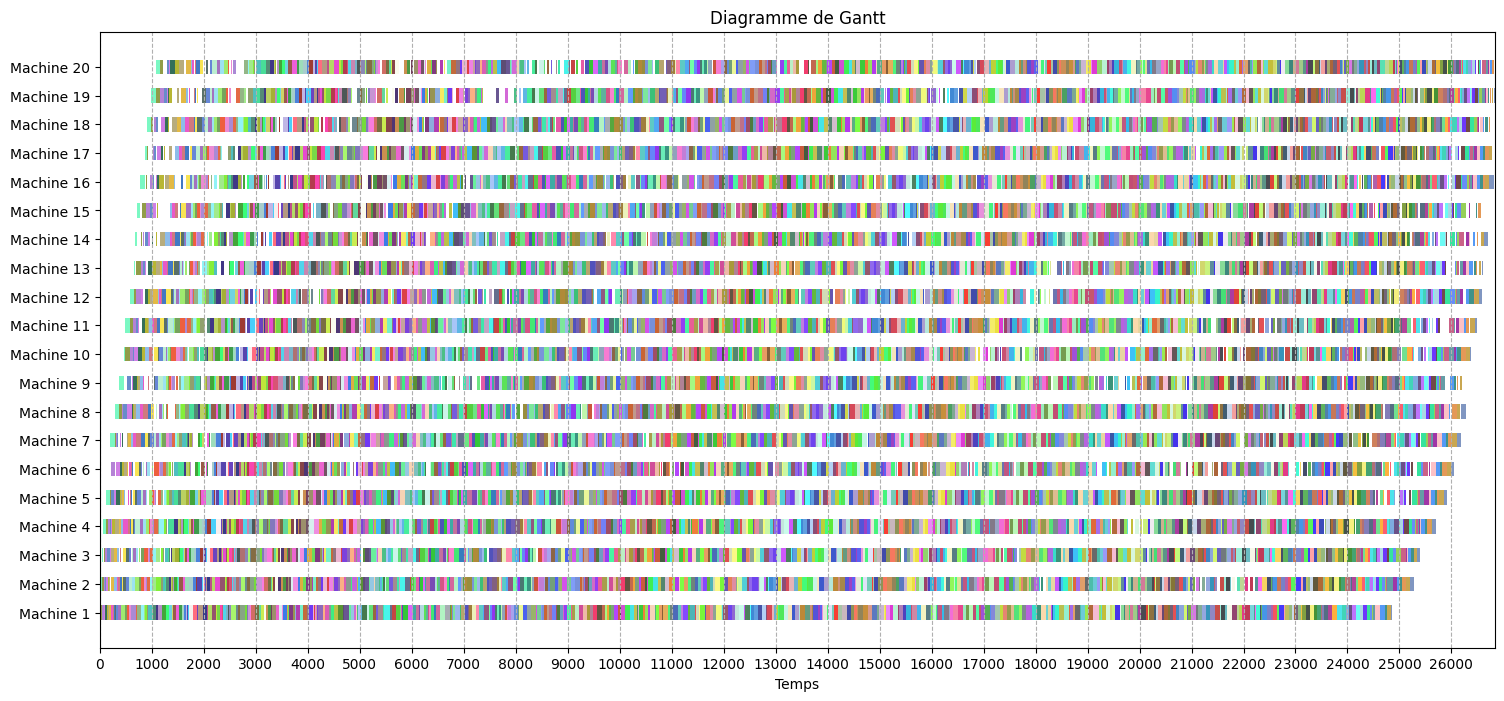

In [50]:
sequence_neh, schedules, cmax_neh, runtime_neh = fs.neh_heuristic()
print(f"Cmax = {cmax_neh} | Upper Bound = {ub} | Lower Bound = {lb}")
print(f"Runtime = {runtime_neh} s")
print(f"Job Sequence : {sequence_neh}")
fs.draw_gantt_chart(schedules,1000,False)

##### - **CDS**

Cmax = 28575 | Upper Bound = 26189 | Lower Bound = 25922
Runtime = 0.3560011386871338 s
Job Sequence : [484, 127, 57, 182, 314, 349, 495, 191, 451, 214, 180, 15, 144, 52, 378, 313, 78, 215, 490, 311, 346, 241, 306, 467, 294, 4, 450, 159, 111, 247, 287, 207, 243, 323, 430, 475, 142, 446, 1, 93, 227, 87, 21, 61, 25, 109, 340, 8, 23, 262, 474, 158, 209, 358, 224, 305, 260, 123, 410, 89, 105, 166, 391, 100, 188, 230, 363, 35, 460, 118, 297, 442, 394, 70, 213, 9, 48, 216, 320, 183, 397, 240, 324, 72, 197, 298, 326, 448, 376, 377, 387, 245, 256, 28, 75, 468, 301, 373, 66, 185, 406, 281, 343, 469, 439, 496, 267, 441, 53, 60, 266, 113, 115, 156, 284, 286, 71, 150, 67, 170, 232, 498, 251, 315, 285, 42, 134, 368, 411, 417, 98, 181, 82, 288, 171, 437, 449, 279, 408, 47, 165, 327, 217, 255, 486, 95, 132, 359, 77, 196, 392, 422, 432, 292, 190, 275, 339, 13, 32, 154, 269, 277, 272, 330, 334, 364, 421, 102, 472, 494, 11, 12, 466, 407, 110, 355, 54, 120, 380, 192, 211, 473, 143, 152, 371, 90, 157, 212

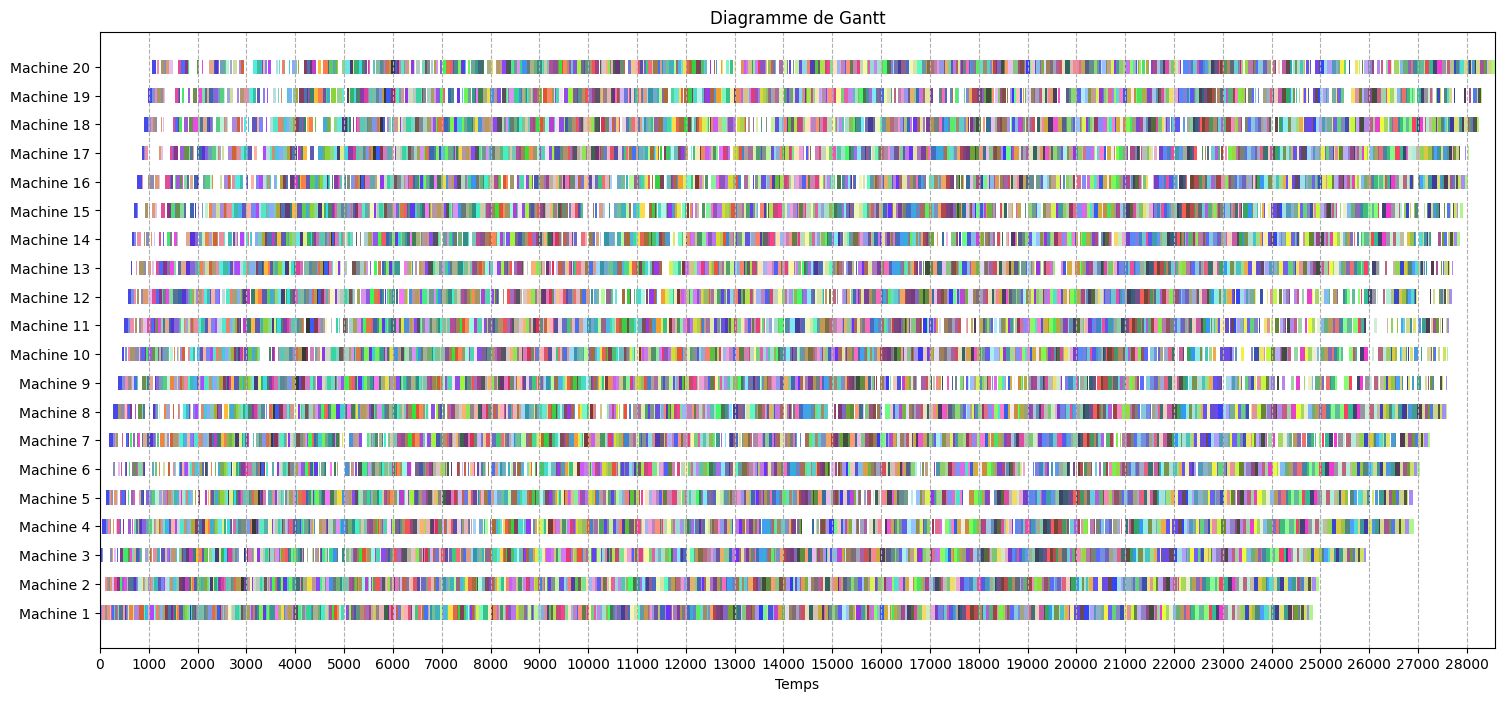

In [47]:
sequence_cds, schedules, cmax_cds, runtime_cds = fs.cds()
print(f"Cmax = {cmax_cds} | Upper Bound = {ub} | Lower Bound = {lb}")
print(f"Runtime = {runtime_cds} s")
print(f"Job Sequence : {sequence_cds}")
fs.draw_gantt_chart(schedules,1000,False)

##### - **Palmer**

Cmax = 28227 | Upper Bound = 26189 | Lower Bound = 25922
Runtime = 0.010214090347290039 s
Job Sequence : [284, 287, 144, 191, 474, 484, 156, 21, 123, 0, 410, 165, 247, 168, 376, 175, 171, 89, 182, 343, 346, 78, 9, 260, 224, 377, 185, 498, 460, 158, 68, 493, 67, 417, 109, 323, 95, 16, 327, 340, 55, 241, 85, 242, 215, 380, 216, 450, 142, 269, 357, 4, 490, 338, 446, 188, 77, 73, 24, 35, 207, 409, 456, 75, 448, 486, 298, 310, 214, 52, 373, 401, 451, 430, 495, 15, 58, 314, 87, 13, 311, 159, 295, 99, 82, 45, 391, 212, 336, 294, 471, 273, 251, 442, 100, 192, 325, 267, 57, 255, 183, 209, 152, 106, 213, 368, 27, 256, 387, 301, 408, 397, 1, 497, 160, 23, 469, 445, 475, 226, 166, 306, 437, 148, 181, 223, 200, 61, 96, 113, 422, 349, 324, 441, 127, 25, 128, 394, 47, 378, 245, 491, 279, 262, 315, 358, 288, 36, 103, 150, 98, 28, 383, 326, 115, 12, 406, 266, 473, 230, 60, 211, 30, 90, 285, 197, 479, 6, 274, 296, 432, 5, 257, 318, 48, 370, 300, 151, 240, 335, 320, 118, 232, 407, 457, 147, 153, 173, 220

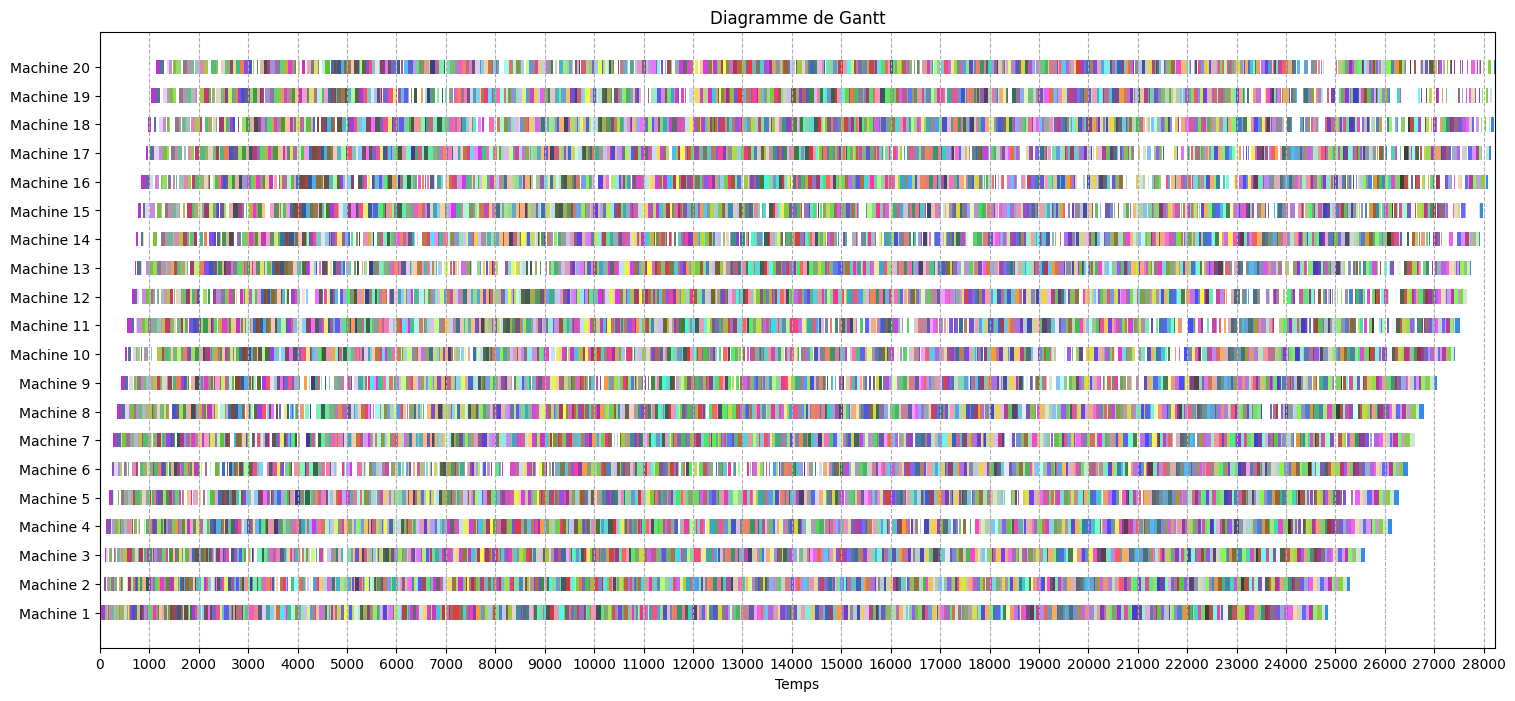

In [51]:
sequence_palmer, schedules, cmax_palmer, runtime_palmer = fs.palmer_heuristic()
print(f"Cmax = {cmax_palmer} | Upper Bound = {ub} | Lower Bound = {lb}")
print(f"Runtime = {runtime_palmer} s")
print(f"Job Sequence : {sequence_palmer}")
fs.draw_gantt_chart(schedules,1000,False)

### Comparaison entre les 3 heuristiques

In [52]:
heuristics = ["NEH","CDS","Palmer"]
runtimes = [runtime_neh,runtime_cds,runtime_palmer]
cmaxes = [cmax_neh,cmax_cds,cmax_palmer]
deviations = [(cmax-ub)/ub for cmax in cmaxes]
comparaison = pd.DataFrame( {
    "Heuristique" : heuristics,
    "Temps d'execution" : runtimes,
    "Cmax" : cmaxes,
    "Deviation" : deviations}
)
comparaison.style.hide(axis="index")

Heuristique,Temps d'execution,Cmax,Deviation
NEH,974.549956,26838,0.024781
CDS,0.356001,28575,0.091107
Palmer,0.010214,28227,0.077819


<table>
 <tr>
    <td rowspan=2>Instances</td>
    <td rowspan=2>Upper bound</td>
    <td colspan="3">NEH</td>
    <td colspan="3">CDS</td>
    <td colspan="3">Palmer</td>
 </tr>

 <tr>
   <td>Cmax</td>
   <td>Runtime</td>
   <td>deviation</td>
   <td>Cmax</td>
   <td>Runtime</td>
   <td>deviation</td>
   <td>Cmax</td>
   <td>Runtime</td>
   <td>deviation</td>
 </tr>

 <tr>
  <td>20 jobs 5 machines</td>
  <td>1278</td>
  <td>1323</td>
  <td>0.04592</td>
  <td>0.03521</td>
  <td>1366</td>
  <td>0.00082</td>
  <td>0.06885</td>
  <td>1384</td>
  <td>0.00134</td>
  <td>0.082942</td>
 </tr>

 <tr>
  <td>20 jobs 10 machines</td>
  <td>1582</td>
  <td>1718</td>
  <td>0.05913</td>
  <td>0.08596</td>
  <td>1815</td>
  <td>0.00324</td>
  <td>0.14728</td>
  <td>1822</td>
  <td>0.00088</td>
  <td>0.151707</td>
</tr>

<tr>
  <td>100 jobs 20 machines</td>
  <td>6286</td>
  <td>6572</td>
  <td>8.22424</td>
  <td>0.01655</td>
  <td>7344</td>
  <td>0.06653</td>
  <td>0.13596</td>
  <td>7289</td>
  <td>0.00133</td>
  <td>0.127456</td>
</tr>

<tr>
  <td>500 jobs 20 machines</td>
  <td>26189</td>
  <td>26838</td>
  <td>974.549</td>
  <td>0.02478</td>
  <td>28575</td>
  <td>0.35600</td>
  <td>0.091107</td>
  <td>28227</td>
  <td>0.01021</td>
  <td>0.077819</td>
</table>